# Statistical Analysis

## Intro

We've conducted sentiment analysis, topic modeling, CCR; and acquired their intermediate results. Now it's time perform some statistical analysis on them.

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
def prep_df(df):
    df.drop(['edit_history_tweet_ids', 'id', 'geo', 'withheld'], axis=1, inplace=True)
    df['created_at'] = pd.to_datetime(df['created_at']).dt.date
    df['sentiment'] = df['sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})
    return df

In [3]:
%%time
# the unfiltered data frame with sentiment labels and topic labels
df_all = pd.read_csv('data/all_tweets_topic_lda.csv')

CPU times: user 19.3 s, sys: 8.02 s, total: 27.3 s
Wall time: 30 s


In [4]:
df_all = prep_df(df_all)

In [5]:
df_all.shape

(8674615, 7)

In [6]:
df_all.head(3)

,created_at,text,month,sentiment,topic_1,topic_2,topic_3
0,2019-04-16,just saw a girl walking barefoot through the j...,4,negative,get day one,day im got,NaN
1,2019-04-16,Just posted a photo https://t.co/opCXaYdNXz,4,neutral,posted photo video,year show get,new time home
2,2019-04-16,My mom just walked in all excited because she ...,4,positive,day im got,NaN,NaN


In [7]:
# hashtag-filtered data frame
df_filtered = pd.read_csv('data/hashtag_filtered_ccr.csv')

In [8]:
df_filtered = prep_df(df_filtered)

In [9]:
df_filtered.shape

(5583, 9)

In [10]:
df_filtered.head(3)

,created_at,text,month,sentiment,topic_1,topic_2,topic_3,bdi_mean,gad_mean
0,2019-04-01,"Do you care for or support a loved one, family...",4,neutral,people amp get,NaN,NaN,0.100520,0.038022
1,2019-04-01,NEW EPISODE OF A GREEN RX IS UP! Learn how hik...,4,positive,new time home,like make dont,NaN,0.146308,0.081965
2,2019-04-22,Talk to a Therapist Online via Skype for Anxie...,4,neutral,new time home,people amp get,NaN,0.143152,0.087496


## Sentiment Labels

### Distribution

Inspect sentiment label distribution for the general tweets:

In [11]:
counts_all = df_all.sentiment.value_counts()
counts_all

neutral     3475428
positive    2975593
negative    2223594
Name: sentiment, dtype: int64

In [195]:
def make_count_plot(value_counts, df_type='general'):
    fig, ax = plt.subplots()

    color_map = {'positive': 'green', 'neutral': 'orange', 'negative': 'red'}

    ax.bar(value_counts.index, value_counts.values,
           color=[color_map[x] for x in value_counts.index],
           label=value_counts.index)

    ax.set_xlabel('Sentiment', fontweight='bold')
    ax.set_ylabel('Count', fontweight='bold')
    ax.set_title(f'Sentiment Counts ({df_type.capitalize()})', fontweight='bold')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Set the y-axis tick labels to the actual values with thousand separators
    formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)

    plt.show()

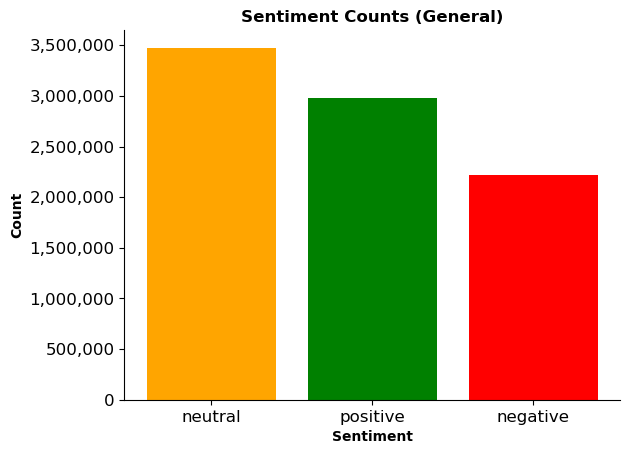

In [192]:
make_count_plot(counts_all)

Look at mental-health-related hashtag-filtered tweets:

In [193]:
counts_filtered = df_filtered.sentiment.value_counts()
counts_filtered

positive    2766
neutral     1797
negative    1020
Name: sentiment, dtype: int64

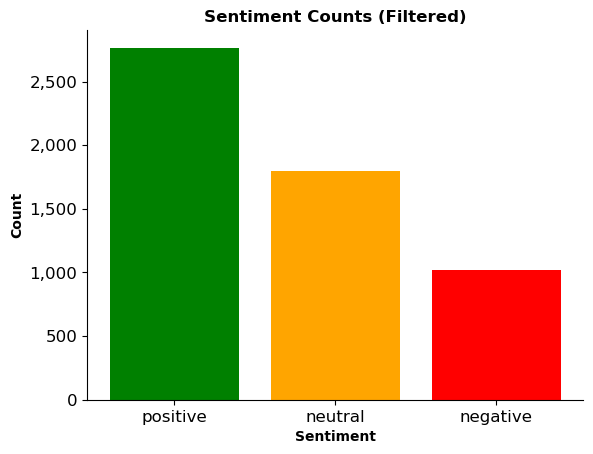

In [194]:
make_count_plot(counts_filtered, df_type='filtered')

Observations:

- In general there are more neutral than positive sentiment tweets
- For mental-health-related tweets, there are more positives than neutrals

### Time-Series Trends

Plot the proportion of the 3 sentiments with respect to each day:

In [196]:
def plot_daily_prop_sentiment(df, df_type='general'):
    # get daily sentiment counts
    daily_proportions_all = df.groupby(['created_at', 'sentiment'])[['month']].count() \
        .reset_index() \
        .rename({'created_at': 'time', 'month': 'count'}, axis=1) \
        .pivot(index='time', columns='sentiment', values='count') \
        .reset_index()

    # get daily sum of all sentiment counts
    daily_proportions_all['sum'] = daily_proportions_all['negative'] \
        + daily_proportions_all['neutral'] + daily_proportions_all['positive']

    # calculate daily proportions
    daily_proportions_all['negative'] = daily_proportions_all['negative'] / daily_proportions_all['sum']
    daily_proportions_all['neutral'] = daily_proportions_all['neutral'] / daily_proportions_all['sum']
    daily_proportions_all['positive'] = daily_proportions_all['positive'] / daily_proportions_all['sum']

    daily_proportions_all = daily_proportions_all.melt(id_vars='time',
                                                       value_vars=['negative', 'neutral', 'positive'],
                                                       value_name='daily_prop')

    # extract month info
    daily_proportions_all['time'] = pd.to_datetime(daily_proportions_all['time'])
    daily_proportions_all['month'] = daily_proportions_all['time'].dt.month
    
    # plot
    fig, axs = plt.subplots(1, len(daily_proportions_all['month'].unique()), figsize=(15, 5), sharey=True)

    color_map = {'positive': 'green', 'neutral': 'orange', 'negative': 'red'}

    month_map = {4: "April", 5: "May"}

    for i, month in enumerate(daily_proportions_all['month'].unique()):
        month_data = daily_proportions_all[daily_proportions_all['month'] == month]
        for sentiment, data in month_data.groupby('sentiment'):
            axs[i].plot(data['time'], data['daily_prop'], label=sentiment, color=color_map[sentiment])
        axs[i].set_xlabel('Time', fontweight='bold')
        axs[i].set_ylabel('Daily Proportion', fontweight='bold')
        axs[i].set_title(f'{month_map[month]}', fontweight='bold')
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].tick_params(axis='both', which='major', labelsize=12)
        axs[i].legend(loc='best')
        axs[i].xaxis.set_tick_params(rotation=45)

    plt.suptitle(f'Daily Proportion of Sentiment ({df_type.capitalize()})', fontweight='bold', fontsize=15)

    plt.show()

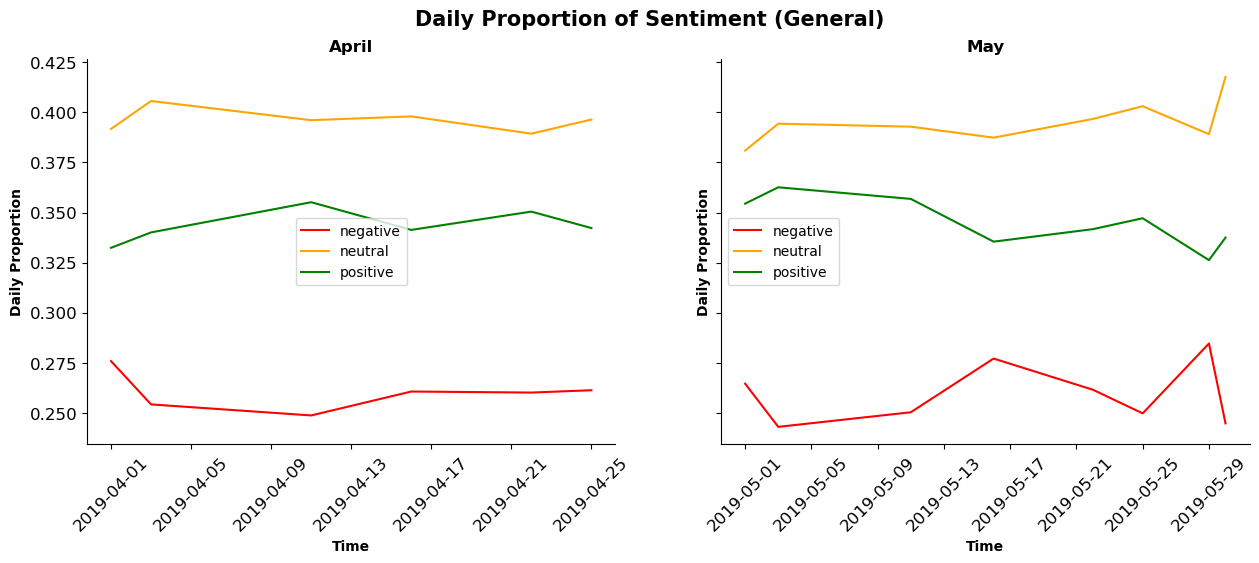

In [200]:
plot_daily_prop_sentiment(df_all, df_type='general')

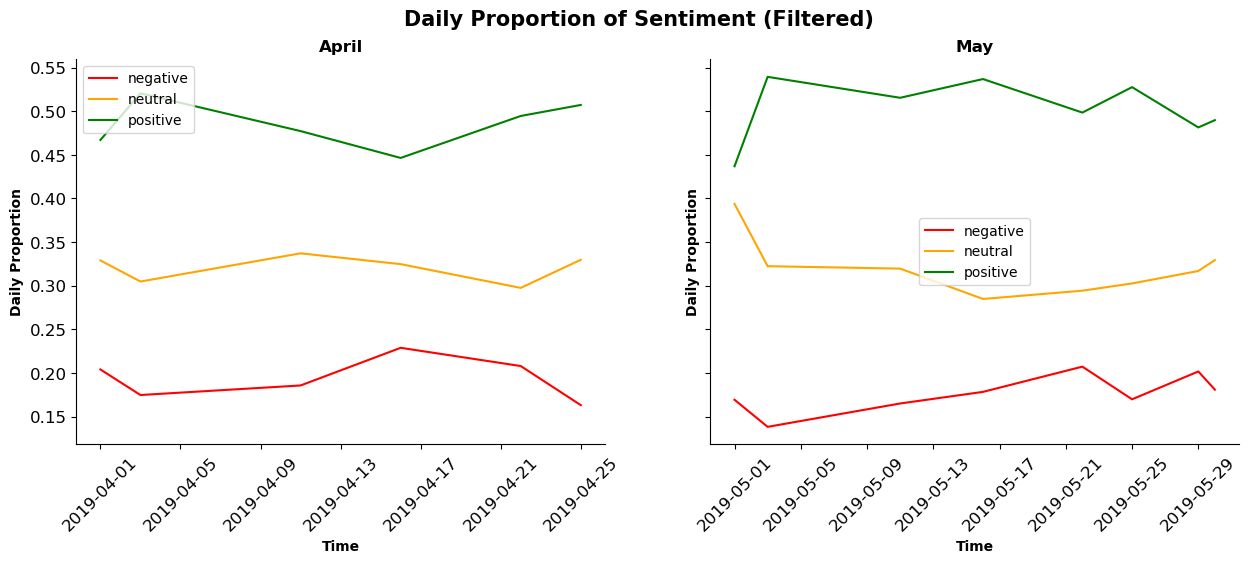

In [201]:
plot_daily_prop_sentiment(df_filtered, df_type='filtered')

Observations:

- April is quite stable for both general and filtered datasets
- In May, we see a decline in the proportion of positive tweets and increase in negative tweets per day

## Topic Labels

### Distribution

In [222]:
def make_topic_count_plot(df, df_type='general'):
    value_counts = df.topic_1.value_counts(ascending=True)
    
    fig, ax = plt.subplots()

    ax.barh(value_counts.index, value_counts.values, label=value_counts.index,
            edgecolor='green', color='mediumseagreen')

    ax.set_ylabel('Topic', fontweight='bold')
    ax.set_xlabel('Count', fontweight='bold')
    ax.set_title(f'Topic Counts ({df_type.capitalize()})', fontweight='bold')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Set the x-axis tick labels to the actual values with thousand separators
    formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
    ax.xaxis.set_major_formatter(formatter)
    
    plt.xticks(rotation=45)

    plt.show()

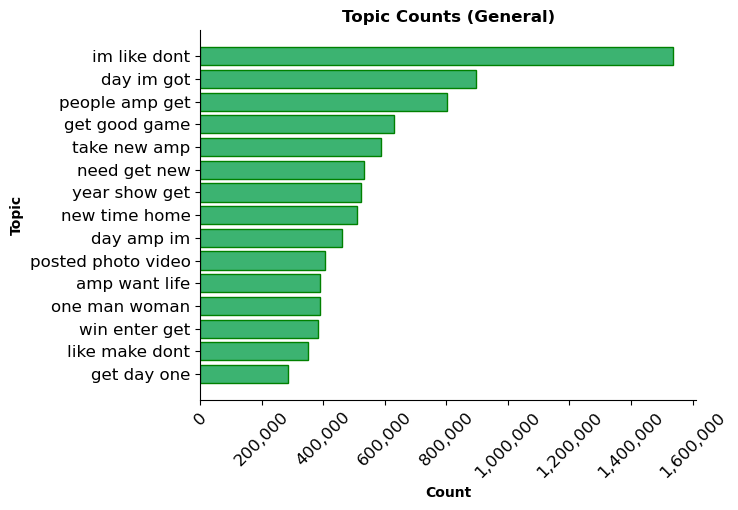

In [223]:
make_topic_count_plot(df_all, df_type='general')

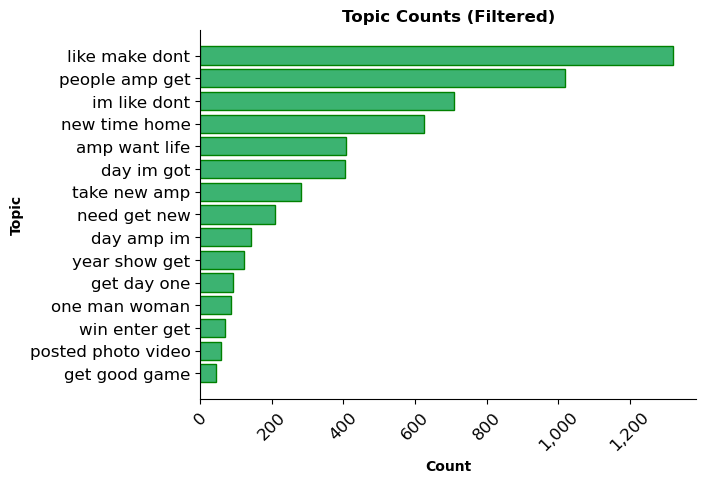

In [225]:
make_topic_count_plot(df_filtered, df_type='filtered')

In [238]:
def make_topic_count_by_month_plot(df, df_type='general'):
    grouped = df.groupby('month')
    month_map = {4: "April", 5: "May"}
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    for i, (month, data) in enumerate(grouped):
        value_counts = data.topic_1.value_counts(ascending=True)

        axs[i].barh(value_counts.index, value_counts.values, label=value_counts.index,
                    edgecolor='green', color='mediumseagreen')

        axs[i].set_ylabel('Topic', fontweight='bold')
        axs[i].set_xlabel('Count', fontweight='bold')
        axs[i].set_title(f'{month_map[month].capitalize()}', fontweight='bold')

        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].tick_params(axis='both', which='major', labelsize=12)

        # Set the x-axis tick labels to the actual values with thousand separators
        formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
        axs[i].xaxis.set_major_formatter(formatter)
        
        axs[i].tick_params(axis='x', rotation=45)
        
    plt.suptitle(f'Topic Counts ({df_type.capitalize()})', fontweight='bold', fontsize=15)
    plt.tight_layout()

    plt.show()

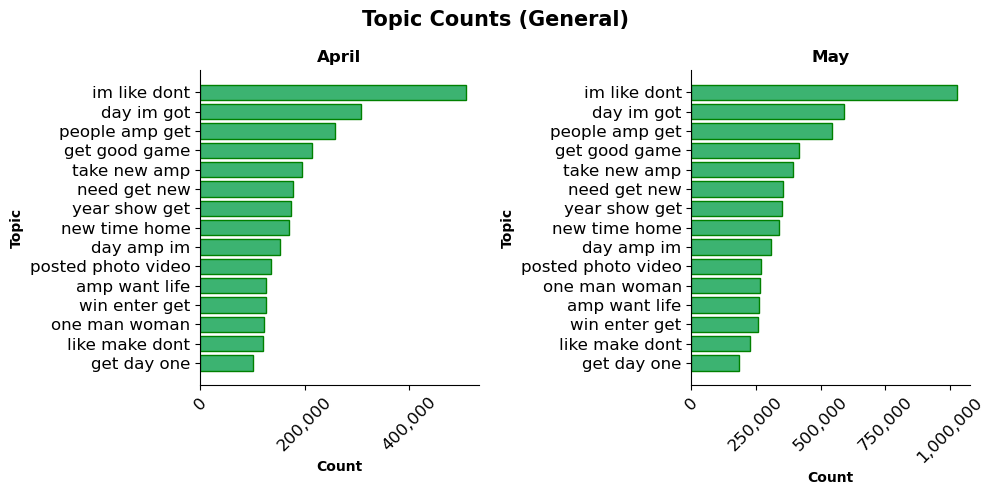

In [239]:
make_topic_count_by_month_plot(df_all, df_type='general')

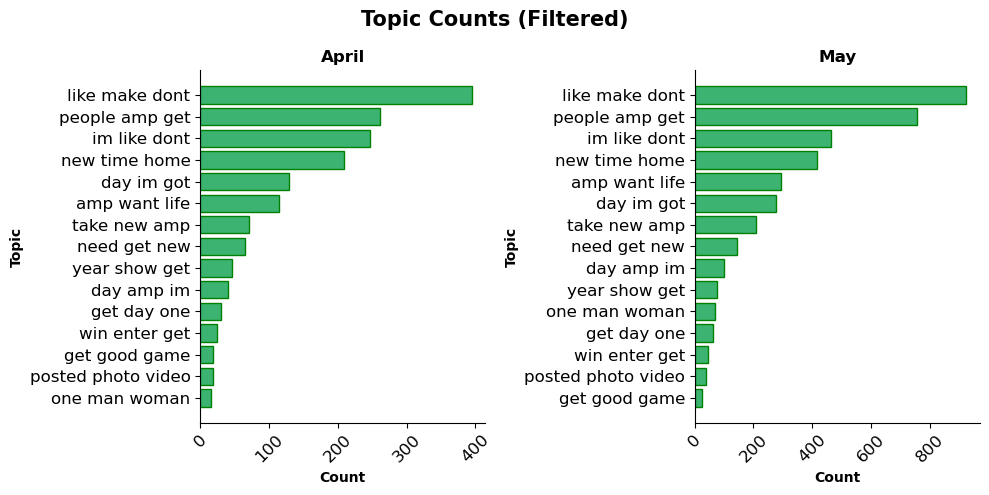

In [240]:
make_topic_count_by_month_plot(df_filtered, df_type='filtered')

Observations:

- The topics picked up by LDA are quite colloquial
- People seem quite upset

### Time-Series Trends

In [273]:
def plot_daily_prop_topics(df, df_type='general'):
    # Select the top 5 most frequent topics
    top_topics = df['topic_1'].value_counts().nlargest(5).index.tolist()

    # Create the subplot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Loop over the top topics and create a line plot for each one
    for i, topic in enumerate(top_topics):
        data = df_all[df_all['topic_1'] == topic].groupby('created_at').size()
        total_counts = df_all.groupby('created_at').size()
        freqs = data / total_counts
        ax.plot(freqs.index, freqs.values, label=topic, linewidth=2, alpha=0.7)

    ax.set_xlabel('Date', fontweight='bold')
    ax.set_ylabel('Daily Proportion', fontweight='bold')
    ax.set_title(f'Daily Proportion of Topics ({df_type.capitalize()})', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    
    caption = '(Note: proportions are with respect to all available topics daily; only the top 5 overall topics are displayed)'
    fig.text(0.5, -0.15, caption, ha='center', fontsize=10)

    plt.show()
    # plt.savefig(f'daily_prop_topics_{df_type}.png', bbox_inches='tight')

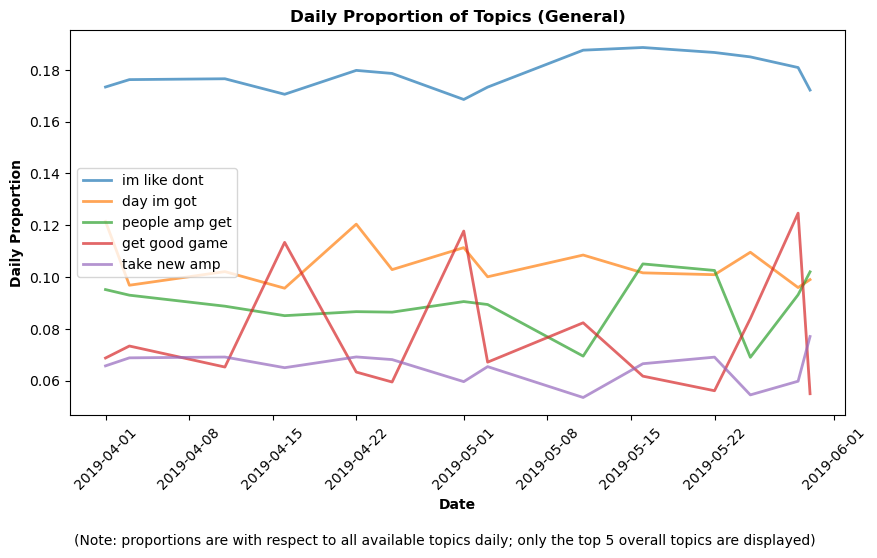

In [274]:
plot_daily_prop_topics(df_all, df_type='general')

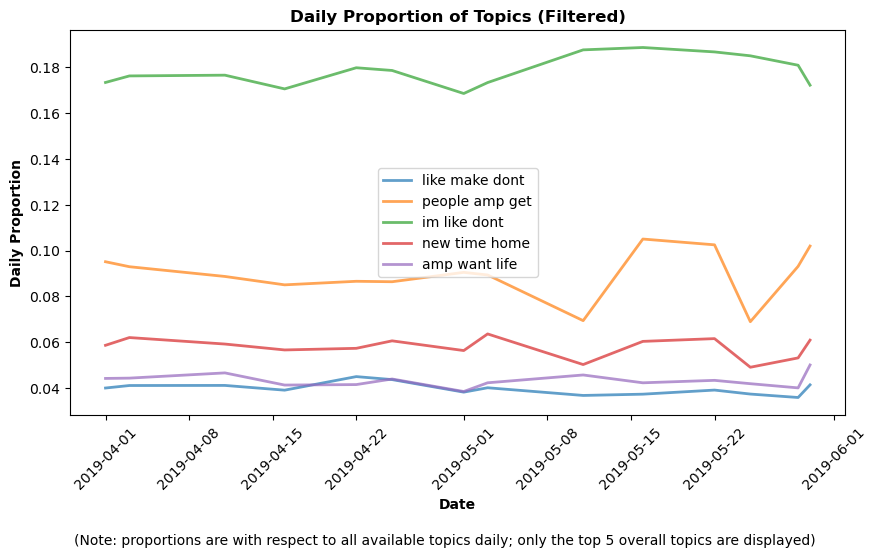

In [275]:
plot_daily_prop_topics(df_filtered, df_type='filtered')